In [35]:
# Import!
import torch
import torch.nn as nn
import torch.optim as optim

import copy
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms

import cv2
import copy
import warnings
warnings.simplefilter("ignore")

In [36]:

# Hyperparameters
# MAX_IMAGE_SIZE = 512

# Optimizer
# OPTIMIZER = 'adam' #or 'lbfgs'
# ADAM_LR = 10
# CONTENT_WEIGHT = 5e0
# STYLE_WEIGHT = 1e2
# TV_WEIGHT = 1e-3 不要
# # NUM_ITER = 500
# SHOW_ITER = 100

# Image Files
# INIT_IMAGE = 'random' # or 'content'
# PRESERVE_COLOR = 'False' # 'False'
# PIXEL_CLIP = 'True' # or False - Clipping produces better images
CONTENT_PATH = 'images/1-content.png'
STYLE_PATH = 'images/1-style.jpg'

# VGG19_PATH = 'models/vgg19-d01eb7cb.pth'
POOL = 'max'

TRANSFER_PATH = './'



In [37]:
mse_loss = torch.nn.MSELoss()

In [38]:
class NueralStyle():
    def __init__(self, content_path, style_path, transform_img_path) -> None:
        self.content_path = content_path
        self.style_path = style_path
        self.transform_img_path = transform_img_path

        self.device = ("cuda" if torch.cuda.is_available() else "mps")
        
        # vgg19モデルの重みのロード
        VGG19_PATH = 'models/vgg19-d01eb7cb.pth'
        vgg = models.vgg19(pretrained=False)
        vgg.load_state_dict(torch.load(VGG19_PATH), strict=False)
        self.model = copy.deepcopy(vgg.features)
        self.model.to(self.device)

        self.CONTENT_WEIGHT = 5e0
        self.STYLE_WEIGHT = 1e2
        self.ADAM_LR = 10
        self.NUM_ITER = 500
        self.SHOW_ITER = 100
        self.PIXEL_CLIP = 'True'
        self.PRESERVE_COLOR = 'False'
        self.OPTIMIZER = 'adam'
        self.MAX_IMAGE_SIZE = 512


        self.content_img = self.load_image(self.content_path)
        self.style_img = self.load_image(self.style_path)

        self.content_tensor = self.itot(self.content_img).to(self.device)
        self.style_tensor = self.itot(self.style_img).to(self.device)



        self.content_layers = ['relu4_2']
        self.content_weights = {'relu4_2': 1.0}
        
        self.style_layers = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3']
        self.style_weights = {'relu1_2': 0.2, 'relu2_2': 0.2, 'relu3_3': 0.2, 'relu4_3': 0.2, 'relu5_3': 0.2}

        self.INIT_IMAGE = 'random'
        self.g = self.initial()
        self.g = self.g.to(self.device).requires_grad_(True)

        learnig_rate = 0.01
        if (self.OPTIMIZER=='lbfgs'):
            self.optimizer = optim.LBFGS([self.g],lr=learnig_rate)
        else:
            self.optimizer = optim.Adam([self.g], lr=self.ADAM_LR)

        # 不要な勾配の更新を消す
        for param in self.model.parameters():
            param.requires_grad = False

    def load_image(self, path):
        img = cv2.imread(path)
        return img
    
    # Show image
    def show(self, img):
        # Convert from BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # imshow() only accepts float [0,1] or int [0,255]
        img = np.array(img/255).clip(0,1)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(img)
        plt.show()

    # Save Image as out{num_iterms}.png
    def saveimg(self, img):
        if (self.PIXEL_CLIP=='True'):
            img = img.clip(0, 255)
        cv2.imwrite('out'+str(self.transform_img_path)+'.png', img)

    # Color transfer
    def transfer_color(self, src, dest):
        if (self.PIXEL_CLIP=='True'):
            src, dest = src.clip(0,255), dest.clip(0,255)

        # Resize src to dest's size
        H,W,_ = src.shape
        dest = cv2.resize(dest, dsize=(W, H), interpolation=cv2.INTER_CUBIC)

        dest_gray = cv2.cvtColor(dest, cv2.COLOR_BGR2GRAY) #1 Extract the Destination's luminance
        src_yiq = cv2.cvtColor(src, cv2.COLOR_BGR2YCrCb)   #2 Convert the Source from BGR to YIQ/YCbCr
        src_yiq[...,0] = dest_gray                         #3 Combine Destination's luminance and Source's IQ/CbCr

        return cv2.cvtColor(src_yiq, cv2.COLOR_YCrCb2BGR)  #4 Convert new image from YIQ back to BGR

    def itot(self, img):
        # Rescale the image
        H, W, C = img.shape
        image_size = tuple([int((float(self.MAX_IMAGE_SIZE) / max([H,W]))*x) for x in [H, W]])
        
        itot_t = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(image_size),
            transforms.ToTensor()
        ])
        
        # means and shared var
        normalize_t = transforms.Normalize([103.939, 116.779, 123.68],[1,1,1])
        tensor = normalize_t(itot_t(img)*255)
        
        # Add the batch_size dimension
        tensor = tensor.unsqueeze(dim=0)
        return tensor

    def ttoi(self, tensor):
        # Add the means. this is ImageNet mean
        ttoi_t = transforms.Compose([
            transforms.Normalize([-103.939, -116.779, -123.68],[1,1,1])])

        # Remove the batch_size dimension
        tensor = tensor.squeeze()
        img = ttoi_t(tensor)
        img = img.cpu().numpy()
        
        # [C, H, W] -> [H, W, C]
        img = img.transpose(1, 2, 0)
        return img


    # not need
    # def pool_(self, pool='avg'):
    #     if (pool=='avg'):
    #         ct=0
    #         for layer in self.model.children():
    #             if isinstance(layer, nn.MaxPool2d):
    #                 self.model[ct] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
    #             ct+=1
    #     elif (pool=='max'):
    #         ct=0
    #         for layer in self.model.children():
    #             if isinstance(layer, nn.AvgPool2d):
    #                 self.model[ct] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    #             ct+=1
    #     return self.model


    def gram(self, tensor):
        B, C, H, W = tensor.shape
        x = tensor.view(C, H*W)
        return torch.mm(x, x.t())

    def content_loss(self, g, c):
        loss = mse_loss(g, c)
        return loss

    def style_loss(self, g, s):
        c1,c2 = g.shape
        loss = mse_loss(g, s)
        return loss / (c1**2) # square of channels

    # VGG Forward Pass
    def get_features(self, tensor):
        # check vgg19 layer
        layers = {
            '3': 'relu1_2',   # Style layers
            '8': 'relu2_2',
            '17' : 'relu3_3',
            '26' : 'relu4_3',
            '35' : 'relu5_3',
            '22' : 'relu4_2', # Content layers
            #'31' : 'relu5_2'
        }

        # Get features
        features = {}
        x = tensor
        for name, layer in self.model._modules.items():
            x = layer(x)
            if name in layers:
                if (name=='22'):   # relu4_2
                    features[layers[name]] = x
                elif (name=='31'): # relu5_2
                    features[layers[name]] = x
                else:
                    b, c, h, w = x.shape
                    features[layers[name]] = self.gram(x) / (h*w)

                # Terminate forward pass
                if (name == '35'):
                    break
                
        return features


    # Generate Initial Image
    def initial(self):
        B, C, H, W = self.content_tensor.shape
        if (self.INIT_IMAGE=='random'):
            tensor = torch.randn(C, H, W).mul(0.001).unsqueeze(0)
        else:
            tensor = self.content_tensor.clone().detach()

        return tensor

    def stylize(self):
        # Get features representations/Forward pass
        c_feat = self.get_features(self.content_tensor)
        s_feat = self.get_features(self.style_tensor)
        
        result_img = None
        counter = [0]
        while counter[0] < self.NUM_ITER:
            def closure():
                # Zero-out gradients
                self.optimizer.zero_grad()

                # Forward pass
                g_feat = self.get_features(self.g)

                # Compute Losses
                c_loss=0
                s_loss=0
                for j in self.content_layers:
                    c_loss += self.content_weights[j] * self.content_loss(g_feat[j], c_feat[j])
                for j in self.style_layers:
                    s_loss += self.style_weights[j] * self.style_loss(g_feat[j], s_feat[j])
                
                c_loss = self.CONTENT_WEIGHT * c_loss
                s_loss = self.STYLE_WEIGHT * s_loss
                total_loss = c_loss + s_loss

                # backward
                total_loss.backward(retain_graph=True)
                
                # イテレーションの表示
                counter[0]+=1

                # SHOW_ITER= 100, NUM_ITER = 500
                if (((counter[0] % self.SHOW_ITER) == 1) or (counter[0]==self.NUM_ITER)):
                    print("Style Loss: {} Content Loss: {} Total Loss : {}".format(s_loss.item(), c_loss.item(), total_loss.item()))
                    if (self.PRESERVE_COLOR=='True'):
                        g_ = self.transfer_color(self.ttoi(self.content_tensor.clone().detach()), self.ttoi(self.g.clone().detach()))
                    else:
                        g_ = self.ttoi(self.g.clone().detach())
                    self.show(g_)
                    self.saveimg(g_)
                    plt.show()
                return (total_loss)
            
            # Weight/Pixel update
            self.optimizer.step(closure)
        return self.g

Style Loss: 63067212.0 Content Loss: 1237537.625 Total Loss : 64304748.0


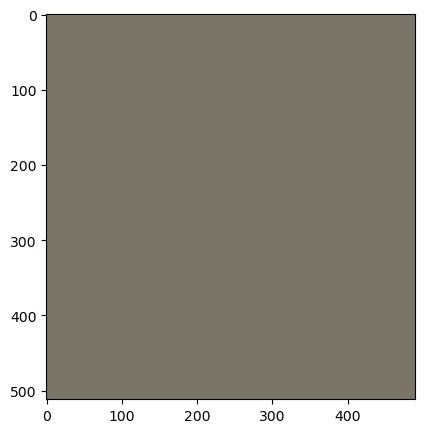

Style Loss: 270250.1875 Content Loss: 867291.9375 Total Loss : 1137542.125


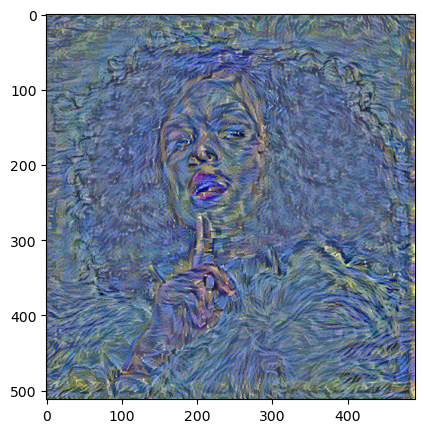

Style Loss: 215914.09375 Content Loss: 722987.5 Total Loss : 938901.625


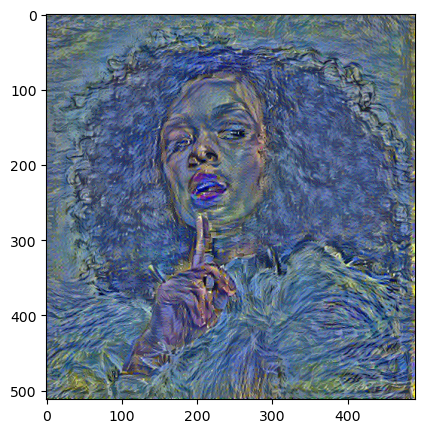

Style Loss: 133609.359375 Content Loss: 645903.1875 Total Loss : 779512.5625


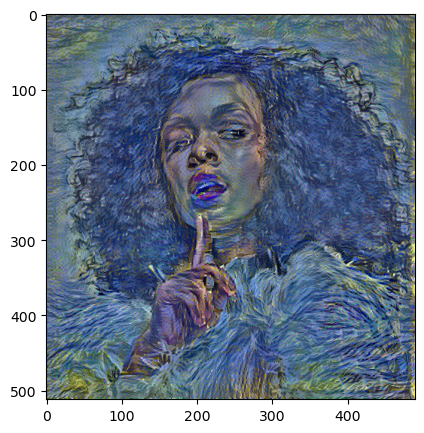

Style Loss: 227427.6875 Content Loss: 595846.375 Total Loss : 823274.0625


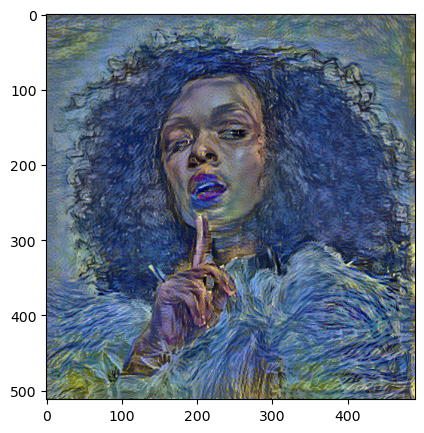

Style Loss: 317923.59375 Content Loss: 677549.625 Total Loss : 995473.25


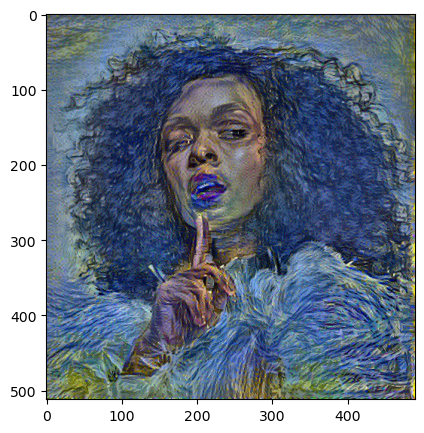

tensor([[[[  34.3531,  -27.8146,  -21.7101,  ...,  -50.9937,  -54.4444,
            -47.0284],
          [ 214.2184,  122.8371,   14.1177,  ...,   30.2872,  -57.9507,
            -45.1396],
          [  -4.8902,  -19.1994,  -32.5826,  ...,   10.4983,    4.6730,
            -21.2746],
          ...,
          [ -59.0176,    8.6675,  -12.8606,  ...,   61.5877,  -86.9234,
            -93.1749],
          [  41.3167,   62.5724,   -7.4387,  ...,   93.8293,  -84.9691,
           -108.9646],
          [ -65.1007, -141.0298, -129.1774,  ...,  228.6409, -105.2030,
           -176.6515]],

         [[ -48.3725, -133.9254,  -24.1201,  ...,   -1.2729,   37.1034,
             63.8963],
          [  14.1652,   -2.2069,   20.0831,  ...,   26.4400,   11.0909,
             23.7363],
          [ -46.8295,  -30.8085,   -3.5857,  ...,   19.1955,   -6.0977,
             39.6505],
          ...,
          [ -61.1523,    5.1293,  124.7183,  ...,    7.1819,  -18.5755,
            127.7071],
          [ -32.98

In [39]:
nueral = NueralStyle(CONTENT_PATH, STYLE_PATH, TRANSFER_PATH)
nueral.stylize()